In [1]:
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
import scipy
import pymc3 as pm
from pymc3 import *
from pymc3.distributions.timeseries import *
from pymc3 import summary
import seaborn as  sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
n = 500

returns = np.genfromtxt("./SP500.csv")[-n:]

model = Model()
with model:
    sigma= Exponential('sigma', 100.0, testval=0.1)

    nu = Exponential('nu', 100.0, testval=5.)

    s = GaussianRandomWalk('s', sigma ** -2, shape=len(returns))

    r = T('r', nu, lam=pm.exp(-2*s), observed=returns)

Model definition in this section. The volitility clustering phenomena observed in financial time series data can be explained by use an exact function to govern the evolution of the volatility (GARCH models) or the use of a stochastic equation. Bayesian models can be used to describe a stochastic equation. The model only uses the last 500 days as defined by variable n. See more information about volatility clustering by Mandelbrot (1963). Basic assumptions are made such as the returns are t distributed. The model is based on the one seen in the paper by Hoffman and Gelman (2011).

In [18]:
with model:
    start = find_MAP(vars=[s], fmin=scipy.optimize.fmin_l_bfgs_b)

    step = NUTS(scaling=start)
    trace = pm.sample(500, step, progressbar=False)

    step = NUTS(scaling=trace[-1])
    trace = pm.sample(2000, step, start=trace[-1], progressbar=True)

 [-----------------100%-----------------] 2000 of 2000 complete in 123.2 sec

This section performs the model fitting on the initial data. The maximum a posteriori is found then used as the starting step for the NUTS algorithm from Hoffman and Gelman (2011). After the first 500 samples are drawn for a burn in and discarded, and the real trace created.

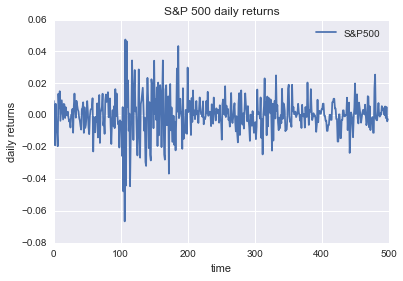

In [19]:
p.plot(returns)
p.ylabel('daily returns')
p.xlabel('time')
p.legend(['S&P500'])
p.title('S&P 500 daily returns')

Plot of daily returns

In [20]:
summary(trace, vars=['nu', 'sigma'])


nu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.948            0.071            0.002            [0.823, 1.091]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.821          0.897          0.946          0.995          1.090


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.129            0.022            0.002            [0.087, 0.168]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.089          0.114          0.128          0.144          0.171



Summary of Bayesian statics of the parameters

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002F34B7F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000002D6EFC50>]], dtype=object)

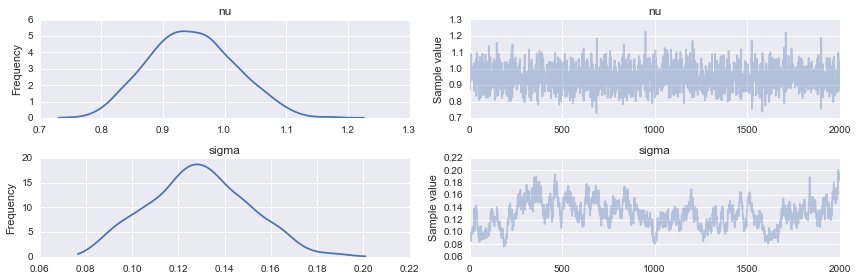

In [21]:
traceplot(trace, vars=['nu', 'sigma'])

Histogram and value of the distributions created by the sampler

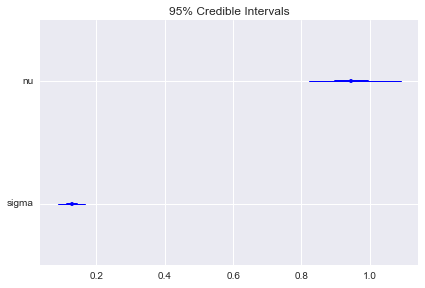

In [22]:
forestplot(trace, vars=['nu', 'sigma'])

Forrest plot displaying confidence intervals of paramters estimated.

(<matplotlib.figure.Figure at 0x2a591710>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002DCD4BA8>],
        [<matplotlib.axes._subplots.AxesSubplot object at 0x0000000035FAE358>]], dtype=object))

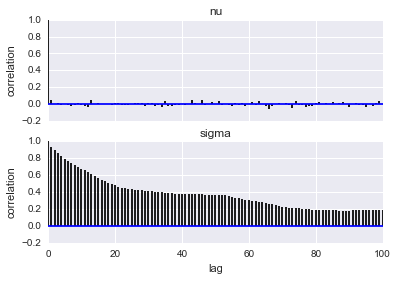

In [23]:
autocorrplot(trace, vars=['nu', 'sigma'])

Plot of autocorrelation

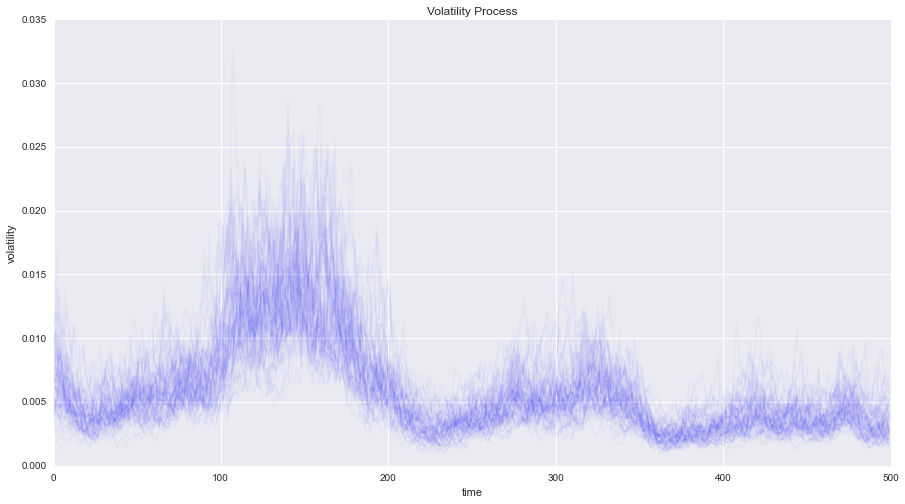

In [24]:
vol = np.exp(trace['s',::30].T)
fig, volplot = p.subplots(figsize=(15, 8))
volplot.plot(vol, 'b', alpha=.03)
volplot.set(title='Volatility Process', xlabel='time', ylabel='volatility')

Volatility plot

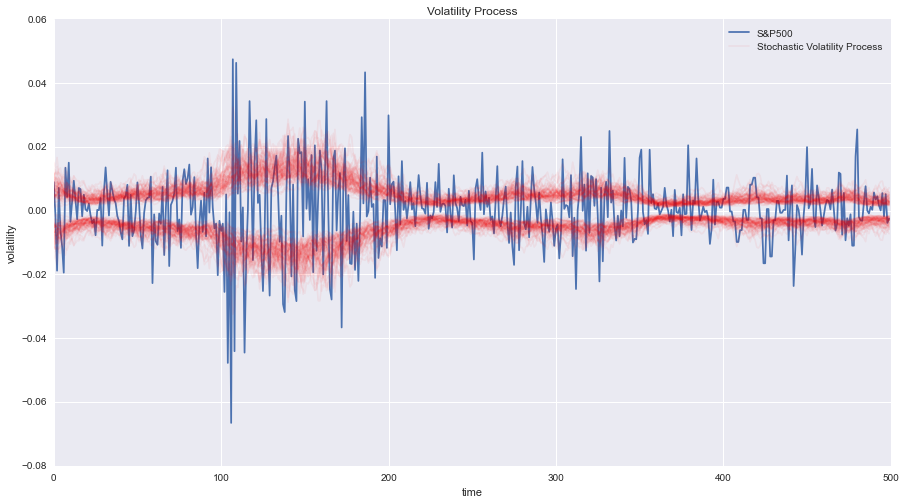

In [25]:
fig, ax = p.subplots(figsize=(15, 8))
ax.set_ylim([-0.08, 0.06])
ax.plot(returns)
ax.plot(vol, 'r', alpha=.05)
ax.plot(-vol, 'r', alpha=.05)
ax.set(title='Volatility Process', xlabel='time', ylabel='volatility')
ax.legend(['S&P500', 'Stochastic Volatility Process'])

Predicted rolling volatility imosed on top of S&P 500 returns.